In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
#Loading the dataset
df = pd.read_csv('Amazon_Stock.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
#Taking only the columns needed for the analysis
df = df[['Date', 'Close']]
df.head(3)

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417


In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

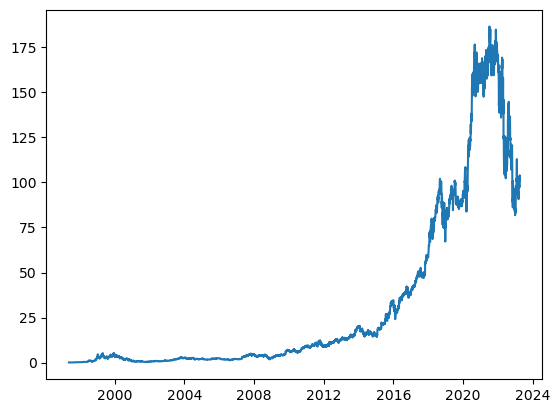

In [8]:
#Plotting the values
plt.plot(df['Date'], df['Close'])

In [9]:
#Dataframe preparation for lstm
from copy import deepcopy

def dataframe_generator(df, nsteps):
    df = deepcopy(df)
    df.set_index('Date', inplace = True)
    
    for i in range(1, nsteps +1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace = True)
    return df

nsteps = 7 #lookingback at last 7 days
df_updated = dataframe_generator(df, nsteps)

In [10]:
df_updated.head(4)

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771


In [11]:
#converting data_frame to numpy data
df_np = df_updated.to_numpy()

In [12]:
df_np.shape

(6509, 8)

In [13]:
# Normalizing the data between -1 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
df_np = scaler.fit_transform(df_np)

In [14]:
df_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [15]:
X = df_np[:, 1:]
y = df_np[:, 0]

In [16]:
#shape must bee matching accordingly
X.shape, y.shape

((6509, 7), (6509,))

In [17]:
#wee need to flip the dataset so that it shows the order as t - nstpe, t-nstep-1, t-step-2 and so on
X = deepcopy(np.flip(X, axis = 1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [18]:
split_index = int(0.80 * len(X))
split_index

5207

In [19]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5207, 7), (5207,), (1302, 7), (1302,))

In [20]:
#Reshaping the training and test set
X_train = X_train.reshape((-1, nsteps, 1))
X_test = X_test.reshape((-1, nsteps, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5207, 7, 1), (5207, 1), (1302, 7, 1), (1302, 1))

In [21]:
# Converting the data as tensor
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([5207, 7, 1]),
 torch.Size([5207, 1]),
 torch.Size([1302, 7, 1]),
 torch.Size([1302, 1]))

In [22]:
#time series dataset for training and testing 
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [23]:
train_dataset, test_dataset

(<__main__.TimeSeriesDataset at 0x7fd201fb1250>,
 <__main__.TimeSeriesDataset at 0x7fd201fb1070>)

In [24]:
#Dataloader to load the dataset
from torch.utils.data import DataLoader

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([10, 7, 1]) torch.Size([10, 1])


In [25]:
#Create LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
#Buliding the model
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [28]:
# defining functions for training and validating a through a single epoch
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    curr_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        curr_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99:
            avg_loss = curr_loss/100
            print(f'Batach: {batch_index+1}, Loss:{avg_loss}')
            curr_loss = 0.0
        
    print()
    
def validate_one_epoch():
    model.train(False)
    curr_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            curr_loss += loss.item()
    
    avg_loss = curr_loss / len(test_loader)
    
    print('Val loss: {avg_loss}')
    print('***************************************')
    print()

In [29]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    

Epoch: 1
Batach: 100, Loss:0.09242717356537469
Batach: 200, Loss:0.010580664490662457
Batach: 300, Loss:0.0002789606982241821
Batach: 400, Loss:0.0002327885404247354
Batach: 500, Loss:0.00018681417450352455

Val loss: {avg_loss}
***************************************

Epoch: 2
Batach: 100, Loss:0.00011529982155025209
Batach: 200, Loss:0.00014694461127874093
Batach: 300, Loss:9.746098161485862e-05
Batach: 400, Loss:0.00012830480987759075
Batach: 500, Loss:9.227454816027603e-05

Val loss: {avg_loss}
***************************************

Epoch: 3
Batach: 100, Loss:7.32427012280823e-05
Batach: 200, Loss:0.00010297656001057476
Batach: 300, Loss:8.008812934804155e-05
Batach: 400, Loss:4.843624062232266e-05
Batach: 500, Loss:6.562666744912349e-05

Val loss: {avg_loss}
***************************************

Epoch: 4
Batach: 100, Loss:4.939371864566056e-05
Batach: 200, Loss:6.643399610311462e-05
Batach: 300, Loss:9.474568200857902e-05
Batach: 400, Loss:5.717149563906787e-05
Batach: 500, L

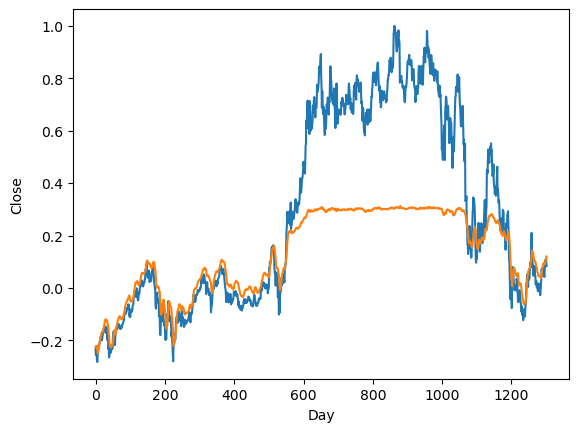

In [31]:
#Prediction
with torch.no_grad():
    predicted = model(X_test.to(device)).numpy()

plt.plot(y_test, label = 'Actual test values')
plt.plot(predicted, label = 'Predicted values')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title()
plt.legend()
plt.show()

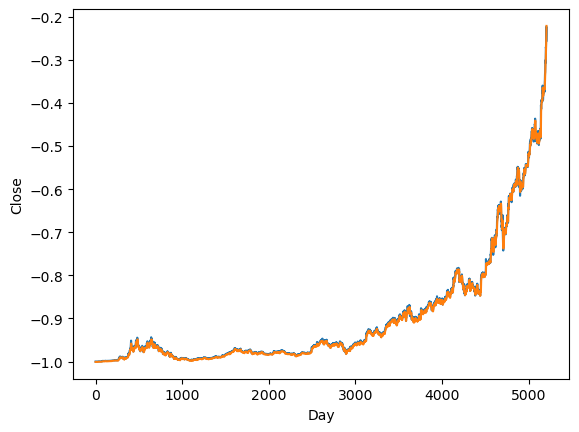

In [32]:
#Prediction
with torch.no_grad():
    predicted = model(X_train.to(device)).numpy()

plt.plot(y_train, label = 'Actual test values')
plt.plot(predicted, label = 'Predicted values')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()